In [14]:
import gym
from stable_baselines3 import PPO
import env.custom_hopper
import optuna
from stable_baselines3.common.evaluation import evaluate_policy

/home/tanguy/Documents/rl_project/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# First grid search for hp tuning. 
lr $\in [10^{-4}, 10^{-3}]$, n_steps $\in \{ 2048, 4096 \}$, batch_size $\in \{ 32 ,64 ,128 \}$, gamma $\in \{ 0.98, 0.985, 0.99, 0.995 \} $, clip_range $\in \{ 0.2, 0.25, 0.3 \}$

In [2]:
def objective(trial: optuna.Trial):
    env = gym.make('CustomHopper-target-v0')
    env.seed(0)  # Set seed for reproducibility

    # Create the PPO model with the current set of hyperparameters
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=trial.suggest_float("learning_rate",1e-4, 1e-3, log=True),
        n_steps=trial.suggest_categorical("n_steps",[2048,4096]),
        batch_size=trial.suggest_categorical("batch_size", [32,64,128]),
        gamma=trial.suggest_float("gamma", 0.98, 0.995, step=0.005),
        clip_range=trial.suggest_float('clip_range', 0.2, 0.3, step=0.05),
        verbose=0,
        seed=0  # Set seed for reproducibility
    )

    # Train the model
    model.learn(total_timesteps=50000)

    # Evaluate the model
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=500)

    # Close the environment
    env.close()

    return mean_reward

In [3]:
study = optuna.create_study(direction='maximize', study_name='ppo hp tuning')
study.optimize(objective, n_trials=50, n_jobs=3)

[I 2024-05-19 16:37:10,191] A new study created in memory with name: ppo hp tuning


/home/tanguy/Documents/rl_project/.conda/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
[I 2024-05-19 17:04:08,440] Trial 0 finished with value: 183.987406244874 and parameters: {'learning_rate': 0.00012870856063994707, 'n_steps': 2048, 'batch_size': 64, 'gamma': 0.985, 'clip_range': 0.3}. Best is trial 0 with value: 183.987406244874.
[I 2024-05-19 17:16:50,525] Trial 1 finished with value: 395.92882120132447 and parameters: {'learning_rate': 0.0005404909242786294, 'n_steps': 2048, 'batch_size': 32, 'gamma': 0.98, 'clip_range': 0.3}. Best is trial 1 with value: 395.92882120132447.
[I 2024-05-19 17:21:05,351] Trial 2 finished with value: 465.7629426689148 and parameters: {'learning_rate': 0.0003541519

In [4]:
print(study.best_params)
print(study.best_value)

{'learning_rate': 0.0007772659318769568, 'n_steps': 2048, 'batch_size': 64, 'gamma': 0.99, 'clip_range': 0.25}
1101.025852767229


## Plot results

In [3]:
with open("hp_tuning_output") as f:
    lines = f.readlines()
import json
data = []
for line in lines:
    reward = float(line.split(' ')[8])
    line = line.replace("'", '"')
    s = line[line.find('{'): line.find('}')+1]
    dict = json.loads(s)
    dict['reward'] = reward
    data.append(dict)

batch size: size of the point
gamma: color
clp range: shape
n steps: dark/light

In [1]:
markers = {0.3 : '*', 0.25 : 'v', 0.2 : 'o'} # clip range
colors = {0.985 : (1,0.2,0.2), 0.98 : (0.2,0.8,0.2), 0.99 : (0.2,0.2,1), 0.995 : (1,0.2,1)} # gamma
def get_color(gamma, n_steps):
    c = colors[gamma]
    r = n_steps/2048
    return c[0]/r, c[1]/r, c[2]/r

Text(0, 0.5, 'Cumulated reward')

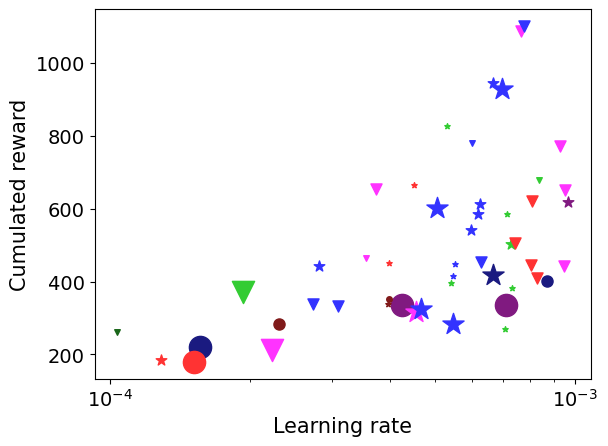

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for d in data:
    ax.scatter(
        [d['learning_rate']],
        [d['reward']],
        c=[get_color(d['gamma'], d['n_steps'])],
        marker=markers[d['clip_range']],
        s=(d['batch_size']/8)**2
    )
ax.set_xscale('log')
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel("Learning rate", fontsize=15)
ax.set_ylabel("Cumulated reward", fontsize=15)

Fine grid search for hp tuning. 
lr $\in [6.5 \times 10^{-4}, 8.5 \times 10^{-4}]$, n_steps = 2048, batch_size = 24, gamma > 0.99, clip_range $\in [0.25, 0.3 ]$

In [15]:
def objective(trial: optuna.Trial):
    env = gym.make('CustomHopper-target-v0')
    env.seed(0)  # Set seed for reproducibility

    # Create the PPO model with the current set of hyperparameters
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=trial.suggest_float("learning_rate", 6.5e-4, 8.5e-4),
        n_steps=2048,
        batch_size=64,
        gamma=trial.suggest_float("gamma", 0.99, 0.995, step=0.001),
        clip_range=trial.suggest_float('clip_range', 0.24, 0.31, step=0.01),
        verbose=0,
        seed=0  # Set seed for reproducibility
    )

    # Train the model
    model.learn(total_timesteps=50000)

    # Evaluate the model
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=500)

    # Close the environment
    env.close()

    return mean_reward

In [16]:
study = optuna.create_study(direction='maximize', study_name='ppo hp tuning')
study.optimize(objective, n_trials=50, n_jobs=3)

[I 2024-05-20 13:59:20,041] A new study created in memory with name: ppo hp tuning
/home/tanguy/Documents/rl_project/.conda/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
[I 2024-05-20 14:36:42,795] Trial 0 finished with value: 464.12103247272967 and parameters: {'learning_rate': 0.0006683927533841489, 'gamma': 0.991, 'clip_range': 0.3}. Best is trial 0 with value: 464.12103247272967.
[I 2024-05-20 14:43:52,907] Trial 1 finished with value: 702.2345547544957 and parameters: {'learning_rate': 0.0008220533091987435, 'gamma': 0.992, 'clip_range': 0.24}. Best is trial 1 with value: 702.2345547544957.
[I 2024-05-20 14:44:56,110] Trial 2 finished with value: 699.3077689943314 and parameters: {'learning_rat

In [ ]:
print(study.best_params)
print(study.best_value)